In [ ]:
!pip install -q transformers datasets tokenizers==0.9.3

# Transformers

Модели трансформеров и библиотека `HuggingFace🤗`. Решим с помощью модели `GPT2` простую задачу (анализ сентимента) и сделаем небольшое исследование карт внимания.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler

from transformers import (GPT2ForSequenceClassification, 
                          GPT2TokenizerFast, 
                          GPT2Config,
                          AdamW,
                          get_linear_schedule_with_warmup
                          )
from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/5276a3f9a2c014ee528f5cca7ad34f185b886acd0f60fe18c61c6768662ca828)


Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000), 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000), 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)})

In [ ]:
emotion_dataset["train"]

Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000)

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

'sadness'

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. 
# Вместо них воспользуемся токенами конца текста.

In [ ]:
tokenizer('I did not feel humiliated')

{'input_ids': [40, 750, 407, 1254, 42659], 'attention_mask': [1, 1, 1, 1, 1]}

Подготовим класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используем его для получения данных для обучения.

P.S. Посмотрим, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумаем, как его надо добавить в датасет.

Немного примеров, как работает токенайзер.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][7])

{'input_ids': [72, 1254, 355, 10416, 546, 1204, 355, 257, 15287, 393, 355, 474, 5286, 355, 257, 614, 1468, 582], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [1]:
# Попрактикуемся работать с токенайзером здесь

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, 
                 tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(self.dataset[self.part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(text, 
                                                 max_length=self.max_length, 
                                                 padding="max_length", 
                                                 return_tensors="pt"
                                                 )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'], 
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation') 
test_dataset = TweetDataset('test')

In [ ]:
batch_size = 64 

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size,
    shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size,
    shuffle=False
)

In [ ]:
# лейблов 6 штук
for part in 'train', 'validation', 'test':
  print(np.unique(emotion_dataset[part]["label"]))

['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']
['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']
['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']




Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels= 6 
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) 
# GPT2 для классификации текста

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
batch = next(iter((train_loader)))

In [ ]:
# return values are of size [batch, sent]
input_ids_tokens = batch['input_ids'].squeeze(1).to(device) 
# Получи токены из датасета
mask = batch['mask'].squeeze(1).to(device) # Получи маску из датасета

In [ ]:
output_batch, _, _ = model_0(input_ids=input_ids_tokens, attention_mask=mask) 

In [ ]:
output_batch.size()

torch.Size([64, 6])

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше

num_epochs = 10

learning_rate = 1e-3
num_warmup_steps = 500

t_total = len(train_loader) * num_epochs

optimizer_grouped_parameters = [
    {"params": [p for n, p in model_0.named_parameters()], 
     "weight_decay": 0.0},
]

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=t_total
)

In [ ]:
from tqdm.notebook import tqdm

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        tokens = batch['input_ids'].squeeze(1).to(device) 
        # Получим токены из датасета
        mask = batch['mask'].squeeze(1).to(device) # Получим маску из датасета
        target = batch['target'].to(device)
        
        optimizer.zero_grad()
        output, _, _ = model_0(input_ids=tokens, attention_mask=mask) 
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens = batch['input_ids'].squeeze(1).to(device) 
            # Получим токены из датасета
            mask = batch['mask'].squeeze(1).to(device) 
            # Получим маску из датасета
            target = batch['target'].to(device)
            
            output, _, _ = model_0(input_ids=tokens, attention_mask=mask) 
            loss = criterion(output, target)
            valid_loss += loss.item()
            valid_acc += (output.argmax(-1) == target).sum()

    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens = batch['input_ids'].squeeze(1).to(device) 
        # Получим токены из датасета
        mask = batch['mask'].squeeze(1).to(device) # Получим маску из датасета
        target = batch['target'].to(device)
        
        output, _, _ = model_0(input_ids=tokens, attention_mask=mask) 
        test_acc += (output.argmax(-1) == target).sum()

print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.1795939721465112,Valid Loss: 0.4322720249183476,Valid Acc: 54.3125



Train Loss: 0.356782939851284,Valid Loss: 0.3985425801947713,Valid Acc: 54.09375



Train Loss: 0.3436121008098125,Valid Loss: 0.34588328702375293,Valid Acc: 54.8125



Train Loss: 0.31380077874660495,Valid Loss: 0.4217407898977399,Valid Acc: 53.84375



Train Loss: 0.295448450922966,Valid Loss: 0.3500589281320572,Valid Acc: 54.59375



Train Loss: 0.26190671369433405,Valid Loss: 0.3117245102766901,Valid Acc: 55.46875



Train Loss: 0.20629830667376517,Valid Loss: 0.28962916950695217,Valid Acc: 55.8125



Train Loss: 0.19057887794077397,Valid Loss: 0.2996403193101287,Valid Acc: 55.9375



Train Loss: 0.1569979255795479,Valid Loss: 0.2956263944506645,Valid Acc: 55.59375



Train Loss: 0.1315493789538741,Valid Loss: 0.286372795002535,Valid Acc: 56.0
Test Acc: 54.875


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0) 
    # [batch, sent]  batch = 1 as we have only one sentence
    attn_tensors = model(inp)[-1]  
    # tuple of tensors [batch, num_heads, sent, sent] 
    # (elements of tuple - attentions for each layer)
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)): # iterations over num_heads
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn), seq

In [ ]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # plt.show()

In [ ]:
text = emotion_dataset['test']['text'][0] # Выберем текст из датасета
tokens = tokenizer.tokenize(text)

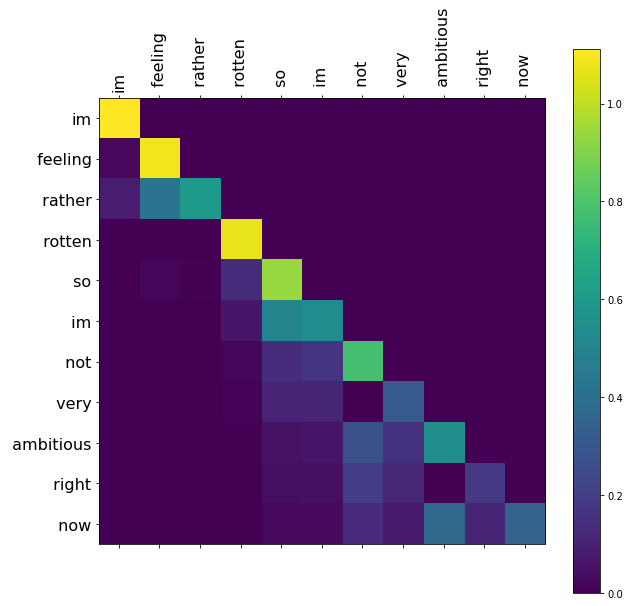

In [ ]:
attns, seq = get_attention_matrixes(model_0, tokenizer, text)
show_attention(seq, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
 # Предполагаемый learning rate. Он может быть больше или меньше 

num_epochs = 10

learning_rate = 1e-6
num_warmup_steps = 500

t_total = len(train_loader) * num_epochs

optimizer_grouped_parameters = [
    {"params": [p for n, p in model_0.named_parameters()], 
     "weight_decay": 0.0},
]

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=t_total
)

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
from tqdm.notebook import tqdm

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        tokens = batch['input_ids'].squeeze(1).to(device) 
        # Получим токены из датасета
        mask = batch['mask'].squeeze(1).to(device) # Получим маску из датасета
        target = batch['target'].to(device)
        
        optimizer.zero_grad()
        output, _, _ = model_1(input_ids=tokens, attention_mask=mask) 
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens = batch['input_ids'].squeeze(1).to(device) 
            # Получим токены из датасета
            mask = batch['mask'].squeeze(1).to(device) 
            # Получим маску из датасета
            target = batch['target'].to(device)
            
            output, _, _ = model_1(input_ids=tokens, attention_mask=mask) 
            loss = criterion(output, target)
            valid_loss += loss.item()
            valid_acc += (output.argmax(-1) == target).sum()

    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens = batch['input_ids'].squeeze(1).to(device) 
        # Получим токены из датасета
        mask = batch['mask'].squeeze(1).to(device) # Получим маску из датасета
        target = batch['target'].to(device)
        
        output, _, _ = model_1(input_ids=tokens, attention_mask=mask) 
        test_acc += (output.argmax(-1) == target).sum()
      
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 2.0416510887145995,Valid Loss: 2.092323049902916,Valid Acc: 14.96875



Train Loss: 2.036101692676544,Valid Loss: 2.092323049902916,Valid Acc: 14.96875



Train Loss: 2.0399120059013365,Valid Loss: 2.092323049902916,Valid Acc: 14.96875



Train Loss: 2.0401174864768983,Valid Loss: 2.092323049902916,Valid Acc: 14.96875



Train Loss: 2.0379250135421754,Valid Loss: 2.092323049902916,Valid Acc: 14.96875



Train Loss: 2.0391584639549256,Valid Loss: 2.092323049902916,Valid Acc: 14.96875



Train Loss: 2.0375716137886046,Valid Loss: 2.092323049902916,Valid Acc: 14.96875



Train Loss: 2.0360114398002627,Valid Loss: 2.092323049902916,Valid Acc: 14.96875



Train Loss: 2.040417776107788,Valid Loss: 2.092323049902916,Valid Acc: 14.96875



Train Loss: 2.038525496482849,Valid Loss: 2.092323049902916,Valid Acc: 14.96875
Test Acc: 14.4375


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset['test']['text'][0] # Выберем текст из датасета
tokens = tokenizer.tokenize(text)

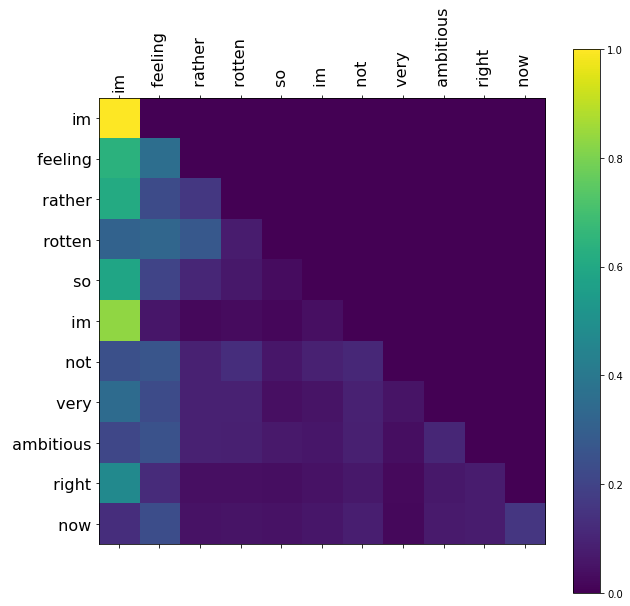

In [ ]:
attns, seq = get_attention_matrixes(model_1, tokenizer, text)
show_attention(seq, attns[-1][0])

1. Какой подход оказался лучше? 
   Лучше обучать модель с нуля для конкретной задачи (в данном случае классификации). 
   Предобученная справилась хуже (непредобученная accuracy примерно 56, предобученная примерно 14)
2. На каких слоях/головах модель обращала внимание?
   В основном на 4-5 слое, головы с 0 по 11
